In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as np
from jax.random import PRNGKey

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import pandas as pd

from models import SEIR_hierarchical, plot_samples, plot_forecast, plot_R0
import util


def gen_covariates(places=None, num_places=5, intercept=False, drop_first=True):
    if places is None:
        places = [f'{i}' for i in range(num_places)]
    places = pd.DataFrame({'place': places})
    covariates = pd.get_dummies(places, drop_first=drop_first)
    if intercept:
        covariates['intercept'] = 1
    return covariates

# Dev: Hierarchical Model

(2050,)


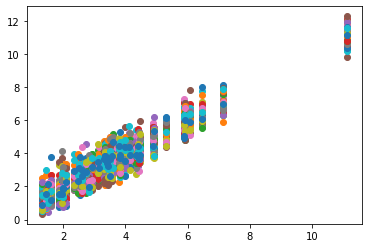

In [11]:
from functools import partial
from glm import glm, GLM, log_link, Gamma

def test_glm():

    data, place_data = util.load_state_Xy()
    alldata = data.join(place_data.drop(columns='state'), how='inner').sort_index()
    
    num_places = len(alldata.index.unique(level=0))
    
    with numpyro.handlers.seed(rng_seed=2):

        model = GLM('1 + C(state, OneHot) + standardize(popdensity)', 
                  alldata,
                  log_link,
                  partial(Gamma, var=0.3),
                  prior=dist.Normal(0, 0.5),
                  guess=3.5,
                  name="R0")
        
        R0, mu, pred = model.sample(shape=(num_places,-1))
        
    plt.plot(mu, R0, 'o')
    plt.show()
    
test_glm()


(164,)
(196,)


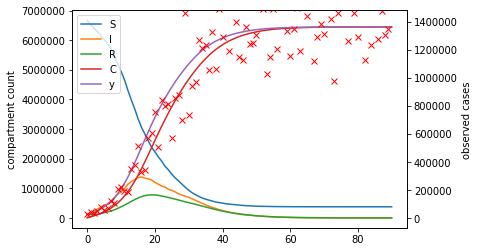

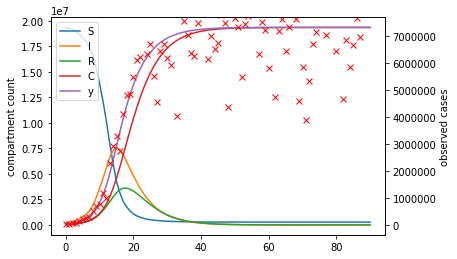

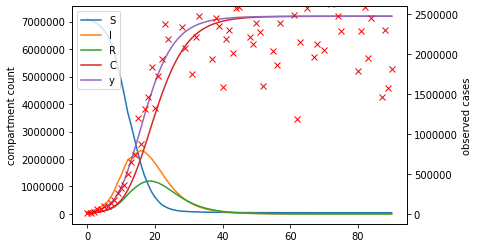

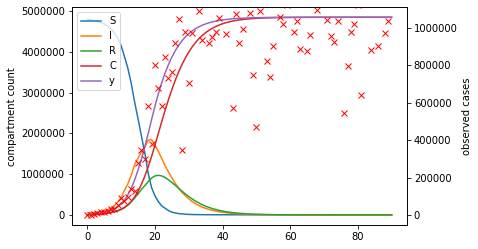

In [18]:
i = 1
num_places = 10
T = 50
T_future = 50
log_scale=False

data, place_data = util.load_state_Xy()
data = data.join(place_data.drop(columns='state'), how='inner')

states = ['MA', 'NY', 'WA', 'AL']
data = data.loc[states,:]
place_data = place_data.loc[states,:]

with numpyro.handlers.seed(rng_seed=i):
    
    beta, xx, yy, oo = SEIR_hierarchical(data=data,
                                         place_data = place_data,
                                         T_future=50)

for x, y, obs_rate in zip(xx, yy, oo):

    T = x.shape[0]
    ts = np.arange(T)

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    l1 = ax1.plot(ts, x)
    l2 = ax2.plot(ts, y, 'x', color='r')

    plt.legend(l1 + l2, ['S', 'I', 'R', 'C', 'y'])

    ax1.set_ylabel('compartment count')
    ax2.set_ylabel('observed cases')

    if log_scale:
        ax1.set_yscale('log')
        ax2.set_yscale('log')

    ylim = np.array(ax1.get_ylim())
    ax2.set_ylim(obs_rate * ylim )

    plt.show()

In [ ]:
#def test_prior_predictive():

data, place_data = util.load_state_Xy()
data = data.join(place_data.drop(columns='state'), how='inner')

states = ['MA', 'NY', 'WA', 'AL']
data = data.loc[states,:]
place_data = place_data.loc[states,:]


predictive = Predictive(SEIR_hierarchical, 
                        posterior_samples = {}, 
                        num_samples=1000)

samples = predictive(PRNGKey(2), data, place_data, T_future=50)


In [ ]:
from models import plot_samples

display(place_data)

num_places = len(states)

for i in range(num_places):

    shared_params = ['gamma_', 'beta_', 'det_rate_']
    place_samples = {k: v[:,i,...] for k, v in samples.items() if not k in shared_params}
    plot_samples(place_samples, T=200, plot_fields=['I', 'y'])
    plt.title('Prior predictive')
    plt.yscale('log') 
    plt.show()
# for i in range(2):
#     test_prior(i, num_places=3, T=50, T_future=50, N=1e8)
#test_prior_predictive()

# Run Inference

In [ ]:
data, place_data = util.load_state_Xy()
data = data.join(place_data.drop(columns='state'), how='inner')

states = ['MA', 'NY']
data = data.loc[states,:]
place_data = place_data.loc[states,:]

args = {
    'data': data,
    'place_data' : place_data,
    'use_obs': True,
    'rw_scale' : 0,
    'det_noise_scale' : 0.3
}

prob_model = SEIR_hierarchical

kernel = NUTS(prob_model,
              init_strategy = numpyro.infer.util.init_to_median())

mcmc = MCMC(kernel, 
            num_warmup=100,
            num_samples=100,
            num_chains=1)

mcmc.run(jax.random.PRNGKey(1), **args)

mcmc.print_summary()
mcmc_samples = mcmc.get_samples()



# Prior samples for comparison
prior = Predictive(prob_model, posterior_samples = {}, num_samples = 1000)
prior_samples = prior(PRNGKey(2), **args)

# Posterior predictive samples for visualization
args['rw_scale'] = 0 # set drift to zero for forecasting
post_pred = Predictive(prob_model, posterior_samples = mcmc_samples)
post_pred_samples = post_pred(PRNGKey(2), T_future=100, **args)

(82,)
(82,)
(82,)
(82,)
(82,)


  0%|          | 0/200 [00:00<?, ?it/s]

(82,)


In [ ]:
from compartment import SEIRModel

gamma = mcmc_samples['gamma'].mean(axis=0)
beta0 = mcmc_samples['beta0'].mean(axis=0)
sigma = mcmc_samples['sigma'].mean(axis=0)

print("gamma", gamma)
print("beta", beta0)
print("sigma", sigma)
print("det_rate", mcmc_samples['det_rate'].mean(axis=0))

print("growth rate", SEIRModel.growth_rate((beta0, sigma, gamma)))

In [ ]:
print(post_pred_samples)

In [ ]:
T = 60
scale = 'log'


places = data.index.unique(level=0)
start = data.index.unique(level=1).min()
num_places = len(places)
print(num_places)


for i, place in zip(range(num_places), places):
    
    t = pd.date_range(start=start, periods=T, freq='D')
    
    shared_params = ['beta0_base', 'gamma_base', 'sigma_base', 'det_rate_base']
    place_samples = {k: v[:,i,...] for k, v in post_pred_samples.items() if not k in shared_params}
    
    t = pd.date_range(start=start, periods=T, freq='D')
    
    positive = data.loc[place].positive
    
    fig, ax = plot_forecast(place_samples, T, positive, t=t, scale=scale)

    #plot_samples(place_samples, plot_fields=['I'], ax=ax, t=t, T=T)
    #plt.plot(obs[i,:], 'o')

    name = place
    plt.suptitle(f'{name} {T} days ')
    plt.tight_layout()
    plt.show()

    
    

In [ ]:
load = True

for place in ['Italy', 'US', 'WA', 'NY', 'MA']:

    if load:
        confirmed = data[place].confirmed[start:]
        start = confirmed.index.min()

        T = len(confirmed)
        N = pop[place]

        filename = f'out/{place}_samples.npz'
        x = np.load(filename, allow_pickle=True)
        mcmc_samples = x['arr_0'].item()
        post_pred_samples = x['arr_1'].item()
        
    
    # Inspect and Save Results

    for scale in ['log', 'lin']:
        for T in [len(confirmed), 30, 40, 50, 100]:

            t = pd.date_range(start=start, periods=T, freq='D')

            fig, ax = plt.subplots(figsize=(14,5))
            plot_samples(post_pred_samples, T=T, t=t, ax=ax, plot_fields=['I', 'y'], model=model)
            plt.title('Posterior predictive')

            confirmed.plot(style='o')

            if scale == 'log':
                plt.yscale('log')

            filename = f'figs/{place}_predictive_scale_{scale}_T_{T}.png'
            plt.savefig(filename)

            plt.show()

    # Compute average R0 over time
    gamma = mcmc_samples['gamma'][:,None]
    beta = mcmc_samples['beta']
    t = pd.date_range(start=start, periods=beta.shape[1], freq='D')
    R0 = beta/gamma

    pi = np.percentile(R0, (10, 90), axis=0)
    df = pd.DataFrame(index=t, data={'R0': R0.mean(axis=0)})
    df.plot(style='-o')
    plt.fill_between(t, pi[0,:], pi[1,:], alpha=0.1)

    filename = f'figs/{place}_R0.png'
    plt.savefig(filename)

    plt.title(place)
    plt.show()

In [ ]:
from compartment import SIRModel, SEIRModel

save = False

beta = mcmc_samples['beta0']
#gamma = np.broadcast_to(mcmc_samples['gamma'][:,None], beta.shape)
gamma = mcmc_samples['gamma']
plt.plot(beta, gamma, '.')
offset = (beta-gamma).mean()

plt.plot([0.+offset, gamma.max()+offset], [0., gamma.max()])
plt.xlabel('beta')
plt.ylabel('gamma')
plt.title('posterior over (beta, gamma)')
plt.legend(['samples', r'gamma = beta + ' + f'{offset:.2f}'])
if save:
    filename = f'figs/{place}_beta_gamma.pdf'
    plt.savefig(filename)
plt.show()


plt.hist(beta/gamma, bins=100)
plt.title('R_0')
plt.xlabel('beta/gamma')
R_0_mean = np.mean(beta/gamma)
print("R0:", R_0_mean)
if save:
    filename = f'figs/{place}_R0.pdf'
    plt.savefig(filename)
plt.show()


growth_rate = SEIRModel.growth_rate((mcmc_samples['beta0'], 
                                     mcmc_samples['sigma'],
                                     mcmc_samples['gamma']))
plt.hist(growth_rate, bins=100)
plt.title('growth rate')
if save:
    filename = f'figs/{place}_growth_rate.pdf'
    plt.savefig(filename)
plt.show()

plt.hist(mcmc_samples['det_rate'], bins=50)
plt.title('det. rate')
if save:
    filename = f'figs/{place}_growth_rate.pdf'
    plt.savefig(filename)
plt.show()


## Tests

In [ ]:
world_data = util.load_world_data()
state_data = util.load_state_data()
data = dict(world_data, **state_data)  # all data

places = list(state_data.keys())
places = ['NY', 'WA', 'MA', 'OH']
#places = ['NY', 'WA']
places = sorted(places)


num_places = len(places)

start = pd.Timestamp('2020-03-04')

place_data = {place: data[place]['data'].confirmed for place in places}
confirmed = pd.DataFrame(data = place_data)[start:]

covariates = pd.get_dummies(pd.Series(places))
covariates['intercept'] = 1
display(covariates)

covariates.shape
covariates.columns[0]
covariates.values

In [ ]:
def gen_covariates(num_places):
    places = [f'{i}' for i in range(num_places)]
    places = pd.DataFrame({'place': places})
    covariates = pd.get_dummies(places)
    covariates['intercept'] = 1
    return covariates

gen_covariates(5)


In [ ]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

x = np.arange(10)
for i in range(len(colors)):
    y = i*np.arange(10)
    plt.plot(x, y, color=colors[i])


In [ ]:
data, place_data = util.load_state_Xy()
data = data.join(place_data.drop(columns='state'), how='inner')
#print(data.columns)
i, j = 23, 40
display(data.loc['MA'].iloc[:,i:j])
